### Sử dụng model Random forest và dự đoán trên tập test

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#### 1. Bước chuẩn bị dữ liệu

In [2]:
with open("final_model/preprocessor.pkl", "rb") as file:
    preprocessor = pickle.load(file)

In [3]:
with open("final_model/RF.pkl", "rb") as file:
    RF_model = pickle.load(file)

In [4]:
# Load dữ liệu từ tập test
test_df = pd.read_csv("../../../feature_engineering_data/test/arsenal.csv")
test_df["win_percent_diff"] = test_df['win_percent_before_team1'] - test_df['win_percent_before_team2']
test_df["ELO_before_diff"] = test_df['ELO_before_match_team1'] - test_df['ELO_before_match_team2']

In [5]:
test_df.columns

Index(['opponent', 'venue', 'season', 'result', 'win_percent_before_team1',
       'lose_percent_before_team1', 'draw_percent_before_team1',
       'win_percent_before_team2', 'lose_percent_before_team2',
       'draw_percent_before_team2', 'total_goals_before_team1',
       'total_lost_goals_before_team1', 'total_goals_before_team2',
       'total_lost_goals_before_team2', 'ELO_before_match_team1',
       'ELO_before_match_team2', 'ELO_after_match_team1',
       'ELO_after_match_team2', 'average_score_before_match_team1',
       'average_score_before_match_team2', 'date_time',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'win_percent_diff',
       'ELO_before_diff'],
      dtype='object')

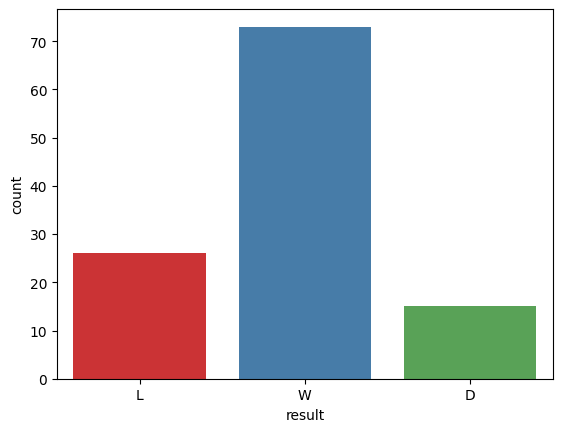

In [6]:
sns.countplot(x="result", data=test_df, palette="Set1");

In [7]:
test_df_with_opponent = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

test_df = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

##### Phân chia dữ liệu thành X, y

In [8]:
X_test = test_df.drop("result", axis=1)
y_test = test_df["result"]

#### 2. Chuẩn hoá, encoding dữ liệu

In [9]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df["result"])

In [10]:
# D: 0
# L: 1
# W: 2
y_test

array([1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 1,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2,
       2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 2])

In [11]:
# Xác định các cột phân loại và cột số
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns

numerical_cols, categorical_cols

(Index(['win_percent_before_team2', 'win_percent_diff',
        'lose_percent_before_team2', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
        'ELO_before_match_team2', 'ELO_before_diff',
        'average_score_before_match_team2'],
       dtype='object'),
 Index(['opponent', 'venue', 'season'], dtype='object'))

In [12]:
transformed_X = preprocessor.transform(X_test)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)
transformed_X.head()

X_test = transformed_X

##### Convert mùa giải mới (2023-2024) chưa có trong tập train thành binary

In [13]:
def int_to_binary_array(number, num_bits):
    binary_string = bin(number)[2:]  # Chuyển đổi thành chuỗi nhị phân, bỏ qua '0b' ở đầu
    binary_array = [int(bit) for bit in binary_string]  # Chuyển đổi mỗi ký tự của chuỗi thành một số nguyên
    
    # Điền vào các số 0 phía trước nếu cần thiết để đủ số lượng bit
    while len(binary_array) < num_bits:
        binary_array.insert(0, 0)
    return binary_array

In [14]:
X_test[["season_0", "season_1", "season_2", "season_3", "season_4"]] = int_to_binary_array(24, 5)
X_test.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,1,1,0,0,0,-1.369793,-0.509837,-1.430191,-1.962036,-1.160168,-0.949541,-0.595178,0.026866,-0.823808,-1.807943
1,0.0,1.0,1,1,0,0,0,2.398592,-3.386673,-1.430191,-0.498929,0.383278,0.585860,1.680169,0.207858,-1.083489,2.241178
2,1.0,0.0,1,1,0,0,0,0.514399,-1.948255,0.549578,-1.962036,-0.645686,3.656663,1.680169,0.096995,-1.090165,0.216618
3,0.0,1.0,1,1,0,0,0,-1.369793,-0.509837,2.529346,0.232624,0.383278,-0.437740,-0.595178,-0.467642,-0.851362,-1.807943
4,1.0,0.0,1,1,0,0,0,-1.369793,0.209372,1.539462,0.598401,-0.131204,-0.437740,-0.595178,-0.499034,-0.724754,-1.470516


In [15]:
X_test.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'],
      dtype='object')

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'],

#### Testing

In [16]:
y_pred = RF_model.predict(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Thêm cột kết quả dự đoán vào sau cột thứ 1 của dataframe
test_df.insert(1, "Predicted", label_encoder.inverse_transform(y_pred))
test_df_with_opponent.insert(2, "Predicted", label_encoder.inverse_transform(y_pred))

test_df_with_opponent.to_csv("test_results.csv", index=False)

### Confusion matrix

In [17]:
# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RF_model.classes_)
cm

array([[ 5,  2,  8],
       [ 5,  7, 14],
       [ 6,  4, 63]], dtype=int64)

In [18]:
# Tính toán accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6578947368421053


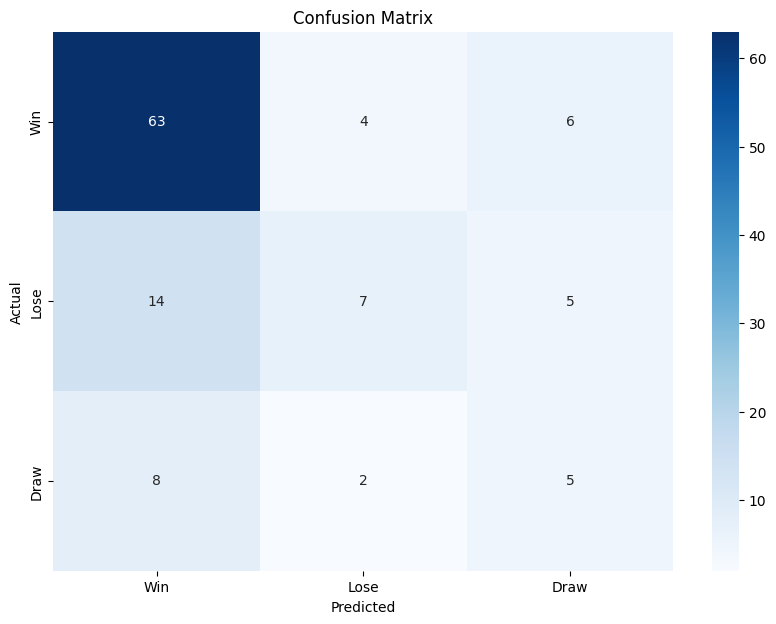

In [19]:
# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]
cm = cm[desired_indices][:, desired_indices]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_labels, yticklabels=desired_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
results_df = pd.DataFrame(test_df["Predicted"] == test_df["result"], columns=["Correct"])